# Presto Demo
Let's put everything together by simulating a user-facing product recommendation system:
- Pick a category (books, music)
- Enter a search term
- Get a page full of results including recommendations

In [213]:
%load_ext autoreload
%autoreload 

import time

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.text import Text
from matplotlib.artist import Artist
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.patches import Rectangle

import pandas as pd

import shared.query as q
import shared.viz as viz
import shared.format as format

viz.set_style()
# connect to SQL database containing 7.5M reviews of 1M products:
# to do: download database from a remote source so that the project can run in public
conn = q.connect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
# Overall counts:
# Showcase the size of our underlying data by precomputing summary stats to display.
counts = {
    "Book": pd.read_sql("SELECT COUNT(*) FROM product WHERE category = 'Books'", conn).iloc[0,0],
    "Album": pd.read_sql("SELECT COUNT(*) FROM product WHERE category = 'Music'", conn).iloc[0,0],
    "Author": pd.read_sql("SELECT COUNT(DISTINCT(creator_search)) FROM product WHERE category = 'Books'", conn).iloc[0,0],
    "Artist": pd.read_sql("SELECT COUNT(DISTINCT(creator_search)) FROM product WHERE category = 'Music'", conn).iloc[0,0]
}
counts

{'Book': 212397, 'Album': 768224, 'Author': 126335, 'Artist': 206210}

In [214]:
# Search input
type = 'Book' # possibilities: Book, Album, Artist, Author
search = 'Down and Out in Paris and London'
exact_match = True

# recommender/output settings
max_search_results = 10
max_recommendations = 10
recommender_user_pool_size = 100
recommender_product_pool_size = 1_000
log_verbosity = 1

###################################
# Recommendations
# Find product data based on user input
##################################
assert(type in set(['Artist', 'Album', 'Author', 'Book']))
category = 'Books' if type in ('Author', 'Book') else 'Music'
search_field = 'title' if type in ('Album', 'Book') else 'creator'
t = time.perf_counter()
results = q.get_recommendations(category, search, conn, search_field = search_field, verbosity = log_verbosity)
elapsed = time.perf_counter() - t

product = results['result'].copy()
products = results['results'].copy()
print(f"Found {len(products)} of {format.describe_number(counts[type])} {type}s in {elapsed:.3f} seconds")





find_products: 1 results in 0.006 seconds
0.0075: Found 1 products
0.0118: Got 132 reviews
0.0128: Filtered 117 helpful reviews
0.0581: Got 5888 related reviews of 4377 products by 102 users
0.0585: Filtered 5229 helpful related reviews
0.0621: Filtered 2230 related reviews by user and/or product
0.0661: Created ratings table for 1000 products by 100 users
0.0737: Calculated similarities
0.206: Removed 64 duplicate editions of the same product
0.207: Added product details
Found 1 of 212.4K Books in 0.207 seconds


In [215]:
##################################
# Viz
# Show product data and recommendations
#################################

def inches_from_points(x):
    return x / 72

# Settings
figure_width = 7 # A4 printer paper size: 8.3in x 11.7in
max_line_width = 100
figure_margin_x = 0.5
figure_margin_y = 0.5
figure_backgound_color = 'w'
debug_backgound_color = ('k', 0.1)
debug_layout = True



vertical_margin = inches_from_points(36)
vertical_spacing = inches_from_points(12)
horizontal_margin = inches_from_points(36)

header_height = 0.25
header_font_size = 15
title_font_size = 13

body_font_size = 11

# Search results section
main_product_font_size = 21
subtitle_font_size = 15
subtitle_color = ('k', 0.5)
product_details_height = 4
per_result_height = 0.5

# Ratings + reviews section
ratings_height = 4

# Recommendations
per_recommendation_height = 0.5

#def inches(x_points, y_points) -> tuple:
#    return (x_points / 72, y_points / 72)

#def add_canvas(fig: Figure) -> Axes:
#    """
#    Adds a full-size subplot to a figure, without axes ticks, with inch units. This allows the subplot 
#    to be used as a canvas for adding custom elements in inch coordinats.
#    """
#    ax = fig.add_subplot(111)
#    ax.axis('off')
#    ax.set_xlim(0, fig.get_figwidth())
#    ax.set_ylim(0, fig.get_figheight())
#    return ax

#def create_canvas(figsize) -> Axes:
#    """
#    Creates a figure and Axes used for custom layouts
#    """
#    fig = plt.figure(figsize = figsize)
#    return add_canvas(fig)

#def create_banner(text, height, fontsize = 15, xy = (0, 0.5), verticalalignment = 'center', horizontalalignment = 'left') -> mpl.axes.Axes:
#    ax = create_canvas(figsize = (figure_width, height))
#    ax.annotate(text = text, xy = xy, verticalalignment = verticalalignment, horizontalalignment = horizontalalignment, fontsize = fontsize)
#    return ax

def show_if_needed(ax: mpl.axes.Axes):
    if debug_layout:
        viz.show_layout(ax.figure, facecolor = debug_backgound_color)

def add_section(height, title: str = None) -> Axes:
    fig = plt.figure(figsize = (figure_width, height), layout = None)
    ax = fig.add_subplot(111)
    ax.axis('off')
    ax.set_xlim(0, fig.get_figwidth())
    ax.set_ylim(0, fig.get_figheight())
    if title:
        ax.set_title(title, loc = 'left', fontsize = header_font_size)
    return ax

def add_text(ax: Axes, text, /, xy, fontsize = 11, fontweight = 'regular', color = 'k', verticalalignment = 'top', horizontalalignment = 'left') -> Text:
    return ax.annotate(
        text, xy, 
        fontsize = fontsize, fontweight = fontweight, 
        color = color, 
        verticalalignment = verticalalignment, horizontalalignment = horizontalalignment
    )
    
def add_box(ax, edgecolor = None, facecolor = ('k', 0.05)):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.add_patch(Rectangle(xy = (x0,y0), width = x1 - x0, height = y1 - y0, edgecolor = edgecolor, facecolor = facecolor))


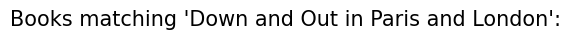

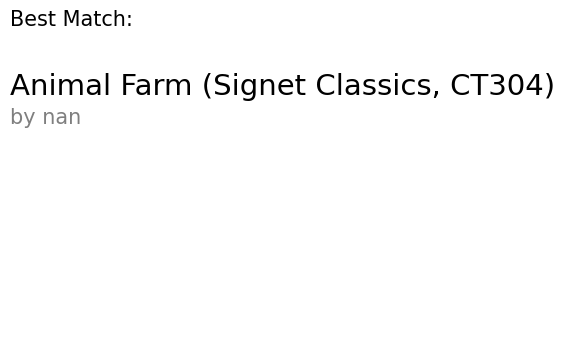

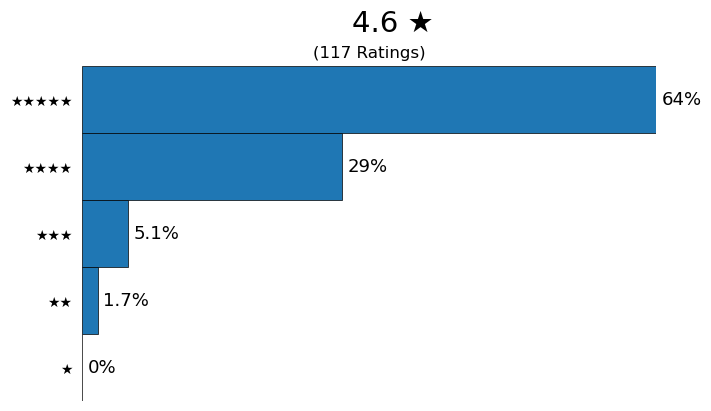

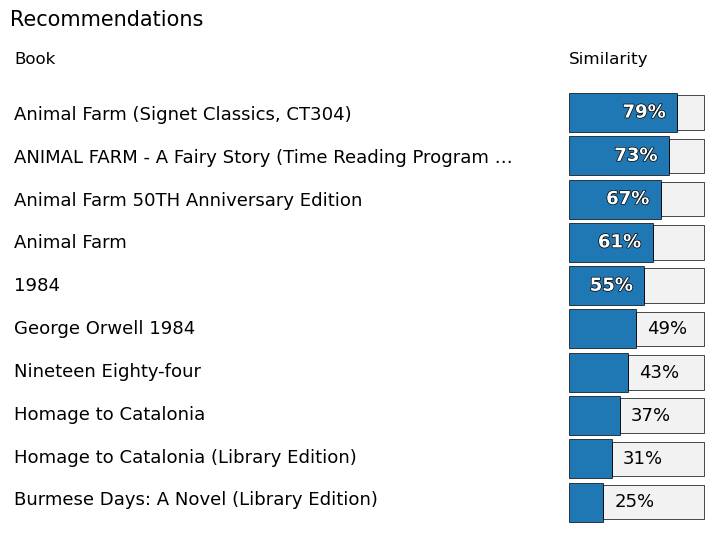

In [ ]:
def product_subtitle(product: pd.Series) -> str:
    # to do: add date
    return f'by {product.creator}'

def wrap_text(text: str, max_line_width):
    if not isinstance(text, str):
        return text
    words = text.split()
    lines = []
    current_line = ''
    for word in words:
        # Check if adding this word exceeds the max width
        if len(current_line) + len(word) > max_line_width:
            # If it does, finalize the current line and start a new one
            lines.append(current_line)
            current_line = word
        else:
            # Otherwise, add the word to the current line
            if len(current_line) > 0:
                current_line += ' '
            current_line += word
    # Add the last line if it's not empty
    if current_line:
        lines.append(current_line)
    return "\n".join(lines)

# Header: explain search
header_text = f'{category} matching {repr(search)}:'
ax = add_section(header_height)
add_text(ax, header_text, xy = (0,header_height), fontsize = header_font_size)

# special case: no results
if product is None:
    height = inches_from_points(body_font_size)
    ax = add_section(height)
    add_text(ax, f'No results found. Try another search.', xy = (0,height), fontsize = body_font_size)
else:
    # Show the best match:
    ax = add_section(height = product_details_height, title = 'Best Match:')
    y = product_details_height - vertical_margin
    add_text(ax, f'{product.title}', xy = (0,y), fontsize = main_product_font_size)
    y -= inches_from_points(main_product_font_size) + vertical_spacing
    add_text(ax, product_subtitle(product), xy = (0, y), fontsize = subtitle_font_size, color = subtitle_color)
    y -= inches_from_points(subtitle_font_size) + vertical_margin
    desc = wrap_text(product.description, max_line_width)
    add_text(ax, desc, xy = (0, y), fontsize = body_font_size)

    # Show other matches, if any
    # To do

    # Show ratings
    reviews = results['reviews'].copy()
    plt.figure(figsize = (figure_width, ratings_height), layout = 'constrained')
    viz.plot_ratings(reviews.rating)

    ##################
    # Recommendations!
    ##################
    recommendations = results['recommendations'].copy()
    recommendations = recommendations[:max_recommendations]
    # invert y for matplotlib - in math, y starts from the bottom and moves up. When showing a list though, y starts from the top and moves down.
    recommendations = recommendations[::-1]
    count = len(recommendations)

    # Create columns as subplots for a table-like display:
    # Title | Rating | Similarity
    title_column = 'Book' if category == 'Books' else 'Album'
    columns = [title_column, 'Similarity']
    widths = [0.8, 0.2]
    # constrained_layout is to match the layout system used in the rest of the chart
    # Subplot mosaic uses a tighter layout system than the default, so mixing a subplot mosaic with 
    # default subplots leads to misalignment.
    fig, axs = plt.subplot_mosaic([columns], width_ratios = widths, constrained_layout = True) 
    fig.set_figwidth(figure_width)
    fig.set_figheight(per_recommendation_height * count)
    # Nudging y up above 1 increases the title spacing between the figure title and the figure
    # Note that the more intuitive approach of using suplot_adjust does not work because constrained layout does not support it.
    text = plt.suptitle('Recommendations', horizontalalignment = 'left', x = 0, y = 1.075, fontsize = header_font_size)
    for label, ax in axs.items():
        ax.set_axis_off()
        ax.set_title(label, loc = 'left')
    
    # product / title column
    ax = axs[title_column]
    ys = recommendations.index
    bars = ax.barh(ys, width = widths[0] * figure_width, height = 1, color = 'w')
    title_text_limit = 50
    for i, index, bar in zip(range(count), ys, bars):
        product = recommendations.loc[index]
        title = product.title
        if len(title) > title_text_limit:
            title = title[:title_text_limit] + '…'
        ax.annotate(title, xy = (0, bar.get_center()[1]), verticalalignment = 'center', fontsize = title_font_size)
    
    # relevance column
    ax = axs['Similarity']
    xs = recommendations.similarity
    xs = [0.25 + 0.6 * x / count for x in range(count)] # uncomment to test similarity bar
    viz.plot_rates(ys, xs, label_inside_bar_cutoff = 0.5)
    



(<BarContainer object of 10 artists>,
 <BarContainer object of 10 artists>,
 [Text(8, 0, '0%'),
  Text(8, 0, '10%'),
  Text(8, 0, '20%'),
  Text(8, 0, '30%'),
  Text(8, 0, '40%'),
  Text(8, 0, '50%'),
  Text(8, 0, '60%'),
  Text(-8, 0, '70%'),
  Text(-8, 0, '80%'),
  Text(-8, 0, '90%')])

<Figure size 600x500 with 0 Axes>

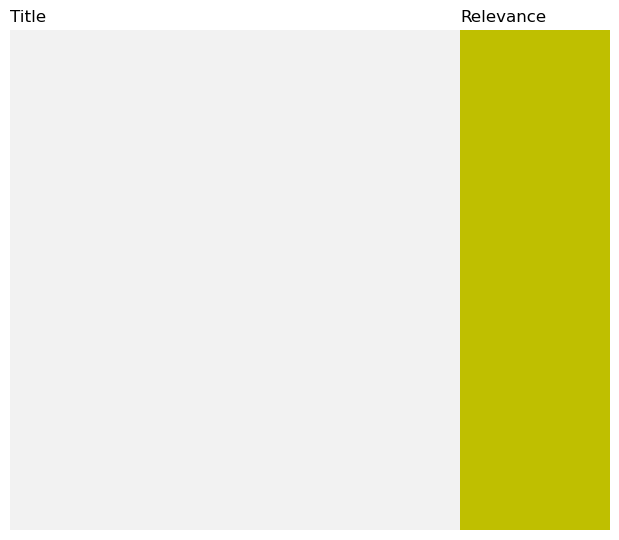

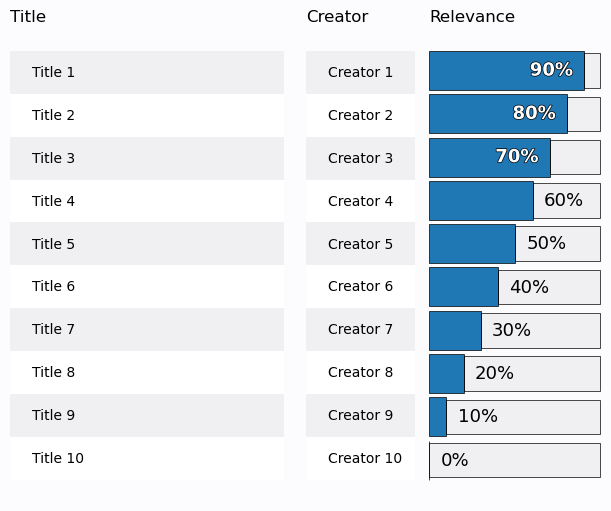

In [ ]:
count = 10
figure_width = 6
row_height = 0.5
row_width = figure_width * 0.75
fig = plt.figure(figsize = (figure_width, row_height * count))
fig.set_facecolor(('y', 0.05))

fig = plt.figure(figsize = (figure_width, row_height * count))
left = fig.add_axes([0, 0, 0.75, 1])
right = fig.add_axes([0.75, 0, 0.25, 1])
left.set_axis_off()
right.set_axis_off()
add_box(left)
add_box(right, facecolor='y')
left.set_title('Title', loc = 'left')
right.set_title('Relevance', loc = 'left')
ys = range(count)



#fig = plt.figure(figsize = (figure_width, row_height * count))
#fig.set_facecolor('y')
titles = ['Title', 'Creator', 'Relevance']
widths = [50,20,30]
# constrained_layout is to match the layout system used in the rest of the chart - subplot mosaic uses a tighter layout system than the default
fig, axs = plt.subplot_mosaic([titles], width_ratios = widths, constrained_layout = True) 
fig.set_figwidth(figure_width)
fig.set_figheight(row_height * count)

fig.set_facecolor(('b', 0.01))
for label, ax in axs.items():
    ax.set_axis_off()
    ax.set_title(label, loc = 'left')
ys = range(count)
ax = axs['Title']
bars = ax.barh(ys, width = 1, height = 1)
xmargin = 16
for i, bar in enumerate(bars):
    i = count - 1 - i
    color = 'w' if i % 2 else ('k', 0.05)
    bar.set_facecolor(color)
    ax.annotate(f'Title {i+1}', xy = (0, bar.get_center()[1]), xytext = (xmargin,0), textcoords = 'offset points', verticalalignment = 'center')

ax = axs['Creator']
bars = ax.barh(ys, width = 1, height = 1)
for i, bar in enumerate(bars):
    i = count - 1 - i
    color = 'w' if i % 2 else ('k', 0.05)
    bar.set_facecolor(color)
    ax.annotate(f'Creator {i+1}', xy = (0, bar.get_center()[1]), xytext = (xmargin,0), textcoords = 'offset points', verticalalignment = 'center')

ax = axs['Relevance']
viz.plot_rates(ys, [i/count for i in range(count)], ax = ax, label_inside_bar_cutoff = 0.65)
#ax.set_xlim(0,1)
#rels = [i/count for i in range(count)]
#bars = ax.barh(ys, width = rels, height = 0.9, edgecolor = 'k', linewidth = 0.5)
#bgbars = ax.barh(ys, width = 1, height = 0.8, edgecolor = 'k', color = ('k', 0.1))
#for i, bar in enumerate(bars):
#    ax.annotate(f'{rels[i]*100:.1f}', xy = (bar.get_width(), bar.get_center()[1]), xytext = (4,0), textcoords = 'offset points', verticalalignment = 'center')

